In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [192]:
IMAGE_SIZE = 256 # Our image size is 256*256 so making a variable for that.
BATCH_SIZE = 40 # Images will be collected in batches.
CHANNELS = 3 # Since we have data in RGB form therefore 3 channels.
EPOCHS = 60 # How many folds for Cross-validation

# Loading the Data

In [3]:
# Now we will load our dataset using tensorflow into a variable names 'dataset'.
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset", # Giving the name of the folder inside which we have our data.
    shuffle = True, # It'll shuffle and load the data.
    image_size = (IMAGE_SIZE,IMAGE_SIZE), # Telling the image size.
    batch_size = BATCH_SIZE # Telling the batch size for which we made a variable in the above cell.
)

Found 1500 files belonging to 4 classes.


# Exploring the Data:

In [4]:
class_names = dataset.class_names
class_names
# Class is nothing but the folders/classifications in our dataset. Which we have to find as the output.

['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']

In [5]:
len(dataset)

38

You can see that the length of the dataset is 38. But why? Its because we've loaded our data in batch size of 40. So when we multiply 38 with 40 we get 1520 and that's exactly the number of images we have. (~1520 may be more because the last batch will not be a perfect 40 if our data set size isn't a multiple of 40)

In [6]:
# As usual the dataset comes in two parts, datapoints and their class. That's what we're extracting.

for image_batch, label_batch in dataset.take(1): # This dataset.take(1) means it'll take only one batch randomly.
    print(image_batch.shape) # This will give us the shape of the batch.
    print(label_batch.numpy()) # This will tell us in which class our image exist. So this will give us 40 values since we have 40 images in a batch.
    # We are using .numpy() because label_batch is a tensor object so we need to use .numpy while printing to increase readability.

(40, 256, 256, 3)
[3 2 2 1 0 3 1 1 1 2 0 1 3 2 0 0 3 0 1 1 2 0 2 2 3 0 1 1 2 3 2 3 1 1 1 1 2
 3 3 3]


As we can see here in the shape, it is basically a tensor(multi dim array) where we have 40 images in the batch, each of size 256 * 256 and the 3 given is for the channel i.e. the RGB. We use RGB values to store the images in the tensor.<br>
In the label_batch we can see classes, i.e to which class each image belongs to. Ex: 1st image belongs to class 3 which is normal class, and so on. <br>
Let's have a look at an individual image:

[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]] 

(256, 256, 3)


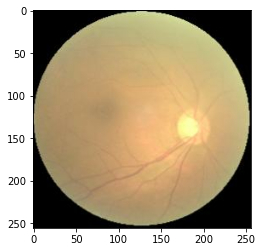

In [8]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].numpy(), '\n') # This is how image is stored using RGB Values.
    print(image_batch[0].shape) # 256 * 256 values for each R, G and B values therefore 3 at the end.
    plt.imshow(image_batch[0].numpy().astype("uint8")) # Ploting the image.
# 'imshow()' expects a 3-d array. And we're converting the values to int using '.astype("uint8")'

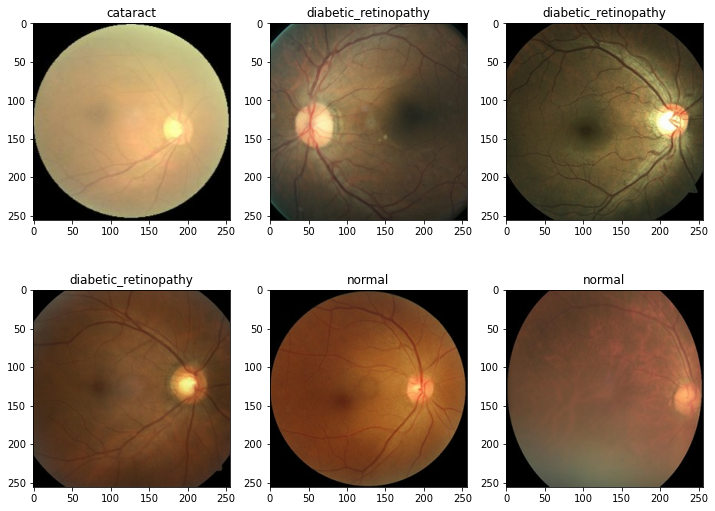

In [102]:
# Lets see 5 images at once:
plt.figure(figsize = (12,9)) # Increasing the size of the plots.
for i in range(6):
    plt.subplot(2,3,i+1) # Making a subplot area where we can plot multiple graphs/images.
    # This last i+1 gives the location where the following plot must be built. Since the location can't be 0 therefore adding 1.
    
    plt.imshow(image_batch[i].numpy().astype("uint8")) # This will be ploted on the current i+1 loc.
    plt.title(class_names[label_batch[i]]) # Giving class title.
    
    # These label_batch, class_names, image_batch are all the variables we created previously.

# Training
### Splitting in train and test dataset:

In [10]:
len(dataset)

38

**Now, lets take 80% of our data for the train set, 10% data for validation and 10% data for test set.**
<br>
Let's do the math,
<br>
Length of our dataset is 132 batches. So, We'll declare 80% of 132 i.e. 105 batches as out train dataset. And from the rest 27 batches lets take 14 for validation and 13 batches for test dataset.
<br>
**Lets create a function which will do all the above stuff for us plus it'll also shuffle the data while splitting so that we get random sets:**

In [11]:
def get_dataset_partitions_tf(ds, train_split = 0.8, validation_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 14) # Seed can be anything.
        
    train_size = int(train_split * ds_size) # Converting in int so that we don't get decimals.
    val_size = int(validation_split * ds_size)
    
    # Partitioning:
    train_ds = ds.take(train_size) # Taking the train datapoints.
    val_ds = ds.skip(train_size).take(val_size) # Skipping those first data points which were taken by test ds and taking the next datapoints.
    test_ds = ds.skip(train_size).skip(val_size) # Whatever is left after skipping the train ds and val ds is test ds therefore no '.take()'.
        
    return train_ds, val_ds, test_ds # Returning the partitions that we made for training, testing and validation.

In [12]:
# Calling the function to do the partition with shuffling.
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [13]:
len(train_ds) # ~80% of data.

30

In [14]:
len(val_ds) # ~10% of data.

3

In [15]:
len(test_ds) # ~10% of data.

5

**Now we'll load the dataset in the cache so that it is loaded in our memory and not much time is wasted on fetching the data from disk everytime.**

In [16]:
# Caching
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

### Standardizing:

Our data is stored in the form of values between 0 and 255 (since the size of our image is 256 * 256). So in order to standardize it we need to divide those values by 255 so that the values comes in the range of 0 and 1. But before that we need to resize them to the original size 255 * 255 because suppose after deployment if anybody supplies an image which is different in size then this will resize it to 256 * 256 and then standardize it.
<br>
Lets do this now:

In [17]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

**Now we'll do data augmentation. Data augmentation is done to make our model more robust. Which means that if anyone gives an image which is rotated or flipped even then our model is able to predict accurately.**

In [18]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

## MODEL BUILDING: 
**(We're gonna use CNN)**

In [193]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale, # First we'll resize and rescale the inputs therefore this.
    data_augmentation, # Then we'll do the augmentation to make the model robust.
    layers.Conv2D(64, (3,3), activation='relu', input_shape = input_shape), # Using CNN Layer. Here 32 is the no. of filters we're using. (3,3) is the filter size.
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])
# CNN has layers which we have built above here in this cell. Every number here is selected after doing hit and trials.
model.build(input_shape=input_shape)

In [194]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_48 (Conv2D)          (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 127, 127, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_49 (Conv2D)          (None, 125, 125, 64)      36928     
                                                                 
 max_pooling2d_49 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                

In [195]:
# Compiling:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [196]:
# Training the model:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/60


30/30 [==============================] - 97s 3s/step - loss: 1.3598 - accuracy: 0.3322 - val_loss: 1.2677 - val_accuracy: 0.3833
Epoch 2/60
30/30 [==============================] - 89s 3s/step - loss: 1.1947 - accuracy: 0.4839 - val_loss: 1.0939 - val_accuracy: 0.5417
Epoch 3/60
30/30 [==============================] - 89s 3s/step - loss: 1.0399 - accuracy: 0.5822 - val_loss: 0.9686 - val_accuracy: 0.5500
Epoch 4/60
30/30 [==============================] - 88s 3s/step - loss: 0.8991 - accuracy: 0.6373 - val_loss: 0.8548 - val_accuracy: 0.6667
Epoch 5/60
30/30 [==============================] - 92s 3s/step - loss: 0.8070 - accuracy: 0.6890 - val_loss: 0.8911 - val_accuracy: 0.6333
Epoch 6/60
30/30 [==============================] - 91s 3s/step - loss: 0.7401 - accuracy: 0.7136 - val_loss: 0.7667 - val_accuracy: 0.7250
Epoch 7/60
30/30 [==============================] - 90s 3s/step - loss: 0.6758 - accuracy: 0.7373 - val_loss: 0.6928 - val_accuracy: 0.7250
Epoch 8/60
30/30 [=============

30/30 [==============================] - 88s 3s/step - loss: 0.1523 - accuracy: 0.9500 - val_loss: 0.1696 - val_accuracy: 0.9167
Epoch 60/60
30/30 [==============================] - 88s 3s/step - loss: 0.1508 - accuracy: 0.9458 - val_loss: 0.2486 - val_accuracy: 0.9000


In [216]:
scores = model.evaluate(test_ds)

5/5 [==============================] - 3s 606ms/step - loss: 0.2195 - accuracy: 0.9300


In [198]:
scores

[0.21952937543392181, 0.9300000071525574]

In [199]:
history.history.keys() # The variable in which we train our model actually containes all the data in a form of list.

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [200]:
history.history['accuracy'] # This will give us a list of all the accuracies we got.

[0.33220338821411133,
 0.4838983118534088,
 0.5822033882141113,
 0.6372881531715393,
 0.6889830231666565,
 0.7135593295097351,
 0.7372881174087524,
 0.7440677881240845,
 0.758474588394165,
 0.7805084586143494,
 0.7779660820960999,
 0.7669491767883301,
 0.800000011920929,
 0.808474600315094,
 0.8152542114257812,
 0.8203389644622803,
 0.8381356000900269,
 0.8220338821411133,
 0.8423728942871094,
 0.8466101884841919,
 0.8661016821861267,
 0.8584745526313782,
 0.8618643879890442,
 0.8728813529014587,
 0.8652542233467102,
 0.8830508589744568,
 0.8728813529014587,
 0.8813559412956238,
 0.8779661059379578,
 0.8872881531715393,
 0.8966101408004761,
 0.8703389763832092,
 0.8966101408004761,
 0.8923729062080383,
 0.8872881531715393,
 0.8940678238868713,
 0.9076271057128906,
 0.8983050584793091,
 0.9118643999099731,
 0.9127118587493896,
 0.9135593175888062,
 0.9076271057128906,
 0.8949152827262878,
 0.9262712001800537,
 0.9203389883041382,
 0.9161016941070557,
 0.9262712001800537,
 0.908474564552

**We can plot these values in a graph:**

In [201]:
# Lets make variables for plotting the graph:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

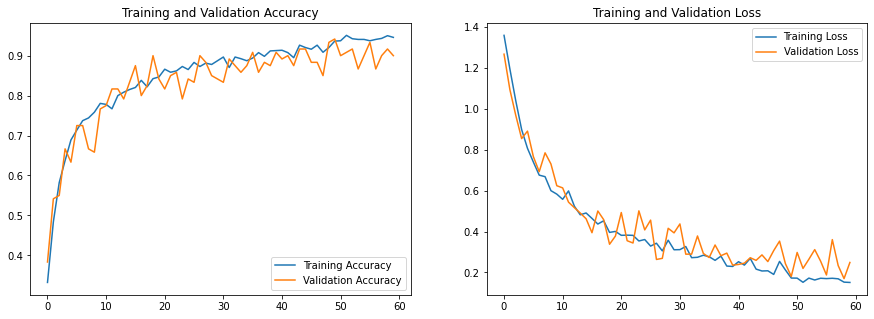

In [202]:
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')

**This looks good. The accuracy is increasing and loss is decreasing.**

### Lets make a prediction by giving our model a datapoint:

First Image to Predict:
Actual Class is: cataract 

2/2 [==============================] - 1s 104ms/step
[7.8365481e-01 4.4626504e-06 7.9045054e-03 2.0843612e-01]
0
Predicted Class is: cataract


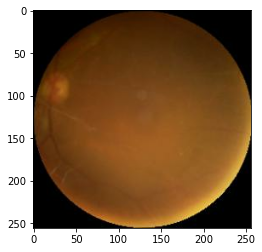

In [95]:
import numpy as np
# Lets only predict for the first image of the batch.
for pred_image_batch, pred_label_batch in test_ds.take(1): # Taking a(1) batch from the test dataset.
    first_image = pred_image_batch[0].numpy().astype('uint8')
    first_label = pred_label_batch[0].numpy()
    
    print("First Image to Predict:")
    plt.imshow(first_image)
    print("Actual Class is:", class_names[first_label], '\n')
    
    # Now we'll predict: We need to predict for the whole batch and then we'll fetch the presiction for the first image.
    batch_prediction = model.predict(pred_image_batch)
    
    print(batch_prediction[0]) # We'll get an array of probabilities. The max will be our ans. We have a function for that called 'argmax'
    print(np.argmax(batch_prediction[0]))
    print('Predicted Class is:', class_names[np.argmax(batch_prediction[0])])

In [96]:
# Lets make a function to do the prediction like above:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy()) # Converting image to an array.
    img_array = tf.expand_dims(img_array, 0) # Creating a batch out of the image array.

    predictions = model.predict(img_array) # Predicting

    predicted_class = class_names[np.argmax(predictions[0])] # Fetching predicted class. Same code as in above cell.
    confidence = round(100 * (np.max(predictions[0])), 2) # Calculating the confidence.
    return predicted_class, confidence

1/1 [==============================] - 0s 40ms/step


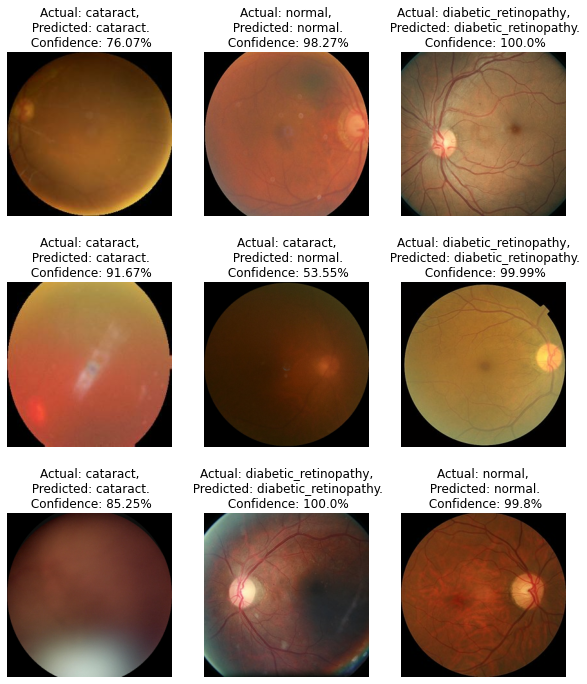

In [215]:
# Using the above function lets predict for 9 images at the same time:
plt.figure(figsize=(10, 12))
for images, labels in test_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy()) # Using the func we made in the above cell.
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off") # This will turn off the axis markings that we used to get in the plots made above in the notebook.

**NOW WE'LL SAVE OUR MODELS:**<br>
Since we change our models to test the accuracy therefore we save their names by version numbers(not necessary). And it may be difficult to keep track of how many models we have tested and what version number name should we give to the current model, so we can automate this process using the following code:

In [111]:
import os

In [210]:
model_version = max([int(i) for i in os.listdir("../saved_models") + [0]]) + 1
model.save(f"../saved_models/{model_version}")
# "os.listdir("../models")" will list all the directories we have in the models folder. And since the directories are names in numbers therefore we can do these things.
# ".." here will take you back to the previous folder from this notebook.
# But if you are saving your model for the first time then run the cell given below and then from the next time this cell will work.

INFO:tensorflow:Assets written to: ../models/4\assets


INFO:tensorflow:Assets written to: ../models/4\assets


In [110]:
# model_version = 1
# model.save(f"../saved_models/{model_version}")

# Lets make a FastAPI server to deploy the project.